## <center>Team-5</center>

## <center>Домашнее задание №2</center>

### 1. Реализовать схему валидации UsersKFoldLeavePOut

Ключевые операции:
- map - преобразовываем строку с лайками пользователя в список лайков
- explode - разворачиваем список лайков в строчки DataFrame для каждого пользователя
- np.split - делим весь DataFrame на равные части, для меньшего потребления памяти на операциях map и explode
- Series.astype(np.uint32 "or" np.uint16) - урезаем потребление памяти на хранение чисел без потери информации

Итоговый размер DataFrame составил 1.1 Gb или 117_450_834 строк

In [ ]:
import pandas as pd
import numpy as np


train_path = "likes/likes_data/train"
test_path = "likes/likes_data/test"

with open(train_path, "r") as train_file:
    user_lines = train_file.read().splitlines()
with open(test_path, 'r') as test_file:
    user_lines.extend(test_file.read().splitlines())

df = pd.DataFrame(data={"item_id": user_lines})
df.index.name = "user_id"
del user_lines

# Строки, загруженные из train и test, делим поровну на N более мелких частей.
# Так уходит меньше памяти на операции explode и map.
# len(df) = 1449998
# делители 1449998: 11(59сек), 17(57сек), 22(56сек,54сек), 34(1мин11сек), 374(58сек), 3877(1мин14сек)
df_parts = np.split(df, 22)
for i, small_df in enumerate(df_parts):
    small_df.loc[:,"item_id"] = small_df.loc[:,"item_id"].map(lambda x: x.split(' '))
    
    small_df = small_df.explode("item_id")
    small_df.item_id = small_df.item_id.astype(np.uint32)
    
    # "order" - меньшее число соответствует более свежему лайку (0 - последний лайк)
    small_df["order"] = small_df.groupby("user_id").cumcount(ascending=False)
    small_df.order = small_df.order.astype(np.uint16)
    
    df_parts[i] = small_df

df = pd.concat(df_parts)
del df_parts

df.reset_index(inplace=True)
df.user_id = df.user_id.astype(np.uint32)
df

,user_id,item_id,order
0,0,333396,53
1,0,267089,52
2,0,155959,51
3,0,353335,50
4,0,414000,49
...,...,...,...
117450829,1449997,448288,4
117450830,1449997,1343,3
117450831,1449997,86420,2
117450832,1449997,186436,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117450834 entries, 0 to 117450833
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  uint32
 1   item_id  uint32
 2   order    uint16
dtypes: uint16(1), uint32(2)
memory usage: 1.1 GB


Для реализации схемы P-Out добавили дополнительное условие `(df[self.order_column] < self.p)` для тестовой маски

In [ ]:
class UsersKFoldPOut():
    def __init__(
        self, n_folds, p, 
        user_column = "user_id", 
        order_column = "order", 
        random_seed=23
    ):
        self.n_folds = n_folds
        self.p = p
        self.user_column = user_column
        self.order_column = order_column
        self.random_seed = random_seed

    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)

        np.random.seed(self.random_seed)
        np.random.shuffle(users)

        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=np.uint32)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users)
            train_mask = ~test_mask
            # В тесте оставляем последние p лайков для каждого пользователя
            final_test_mask = test_mask & (df[self.order_column] < self.p)

            yield train_mask, final_test_mask
            current = stop

In [ ]:
cv = UsersKFoldPOut(n_folds=10, p=3)

for i, (train_mask, test_mask) in enumerate(cv.split(df)):
    train = df[train_mask]
    test = df[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 117305834, Test: 145000
Fold#1 | Train: 117305834, Test: 145000
Fold#2 | Train: 117305834, Test: 145000
Fold#3 | Train: 117305834, Test: 145000
Fold#4 | Train: 117305834, Test: 145000
Fold#5 | Train: 117305834, Test: 145000
Fold#6 | Train: 117305834, Test: 145000
Fold#7 | Train: 117305834, Test: 145000
Fold#8 | Train: 117305835, Test: 144999
Fold#9 | Train: 117305835, Test: 144999


In [ ]:
test

,user_id,item_id,order
53,0,388242,0
82,2,187247,0
491,6,271892,0
747,7,372343,0
1003,8,437395,0
...,...,...,...
117449950,1449989,50870,0
117450205,1449990,165225,0
117450531,1449994,73770,0
117450539,1449995,427576,0


In [ ]:
train

,user_id,item_id,order
0,0,333396,53
1,0,267089,52
2,0,155959,51
3,0,353335,50
4,0,414000,49
...,...,...,...
117450828,1449997,35239,5
117450829,1449997,448288,4
117450830,1449997,1343,3
117450831,1449997,86420,2


In [ ]:
class UsersKFoldPOut():
    def __init__(
        self, n_folds, p, 
        user_column = "user_id", 
        order_column = "order", 
        random_seed=23
    ):
        self.n_folds = n_folds
        self.p = p
        self.user_column = user_column
        self.order_column = order_column
        self.random_seed = random_seed

    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)

        np.random.seed(self.random_seed)
        np.random.shuffle(users)

        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=np.uint32)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users)
            train_mask = ~test_mask
            # В тесте оставляем последние p лайков для каждого пользователя
            final_test_mask = test_mask & (df[self.order_column] < self.p)

            yield train_mask, final_test_mask
            current = stop

In [ ]:
cv = UsersKFoldPOut(n_folds=10, p=3)

for i, (train_mask, test_mask) in enumerate(cv.split(df)):
    train = df[train_mask]
    test = df[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 105755449, Test: 435000
Fold#1 | Train: 105683794, Test: 435000
Fold#2 | Train: 105661911, Test: 435000
Fold#3 | Train: 105668553, Test: 435000
Fold#4 | Train: 105696806, Test: 435000
Fold#5 | Train: 105734724, Test: 435000
Fold#6 | Train: 105695527, Test: 435000
Fold#7 | Train: 105698290, Test: 435000
Fold#8 | Train: 105689899, Test: 434997
Fold#9 | Train: 105772553, Test: 434997


Между train и test нет общих пользователей:

In [ ]:
np.intersect1d(train["user_id"].unique(), test["user_id"].unique())

array([], dtype=uint32)

In [ ]:
test

,user_id,item_id,order
51,0,102795,2
52,0,278503,1
53,0,388242,0
1183,15,371550,2
1184,15,314637,1
...,...,...,...
117447298,1449947,43570,1
117447299,1449947,366502,0
117450203,1449990,289043,2
117450204,1449990,319845,1


In [ ]:
train

,user_id,item_id,order
54,1,174197,9
55,1,335779,8
56,1,141676,7
57,1,119856,6
58,1,376664,5
...,...,...,...
117450829,1449997,448288,4
117450830,1449997,1343,3
117450831,1449997,86420,2
117450832,1449997,186436,1


### 2. Реализовать векторизированную версию метрики PFound:

Кусок кода из публичного решения:

In [ ]:
import pandas as pd
import numpy as np

folder = "yandex_cup_analytics_A"
# считываем данные
qid_url_rating = pd.read_csv(f"{folder}/hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv(f"{folder}/hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])

# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")
qid_url_rating_hostid

,qid,url,rating,hostid
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07,7
2,402111,http://802351.info/5964-v-avstralii.html,0.00,13
3,402111,http://auscommunity.com/blog/jobs/,0.00,53
4,402111,http://auscommunity.com/tag/%D1%84%D0%BE%D1%82...,0.00,53
...,...,...,...,...
798,99543,http://www.youtube.com/watch?v=QDcomRWogFE,0.14,1155
799,99543,http://www.youtube.com/watch?v=Y3n47xZb0b4,0.14,1155
800,99543,http://www.yuga.ru/articles/culture?id=3378,0.00,1156
801,99543,http://www.zexe.de/modules.php?name=Pages&pa=s...,0.14,1160


In [ ]:
# Для кажого запроса находим ссылку с наибольшим рейтингом по каждому хосту. *.groupby(["qid", 'hostid']).max() 
# После сортируем по не возрастанию рейтинга хостов для каждого запроса. *.sort_values(['qid','rating'], ascending=False)
# Сортировка пригодится далее, когда будем выбирать Топ-К.
max_by_qid_hostid = qid_url_rating_hostid.groupby(["qid", 'hostid']).max().sort_values(['qid','rating'], ascending=False)
max_by_qid_hostid

url  rating
qid    hostid                                                           
692308 1035             http://www.rucomedy.com/resident/pushnoi    0.61
       551         http://tnt-online.ru/smotret-comedy-club.html    0.41
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM    0.41
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...    0.14
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...    0.14
...                                                          ...     ...
5308   734                                   http://www.cmcc.ru/    0.00
       767                                http://www.domain.com/    0.00
       866                  http://www.irm.ru/content/domen.html    0.00
       1050                         http://www.sites.google.com/    0.00
       1097                            http://www.toymotion.com/    0.00

[607 rows x 2 columns]

In [ ]:
# Добавим колонку "rank" для взятия Топ-K ссылок. 
max_by_qid_hostid["rank"] = max_by_qid_hostid.groupby("qid").cumcount()
max_by_qid_hostid

url  rating  rank
qid    hostid                                                                 
692308 1035             http://www.rucomedy.com/resident/pushnoi    0.61     0
       551         http://tnt-online.ru/smotret-comedy-club.html    0.41     1
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM    0.41     2
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...    0.14     3
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...    0.14     4
...                                                          ...     ...   ...
5308   734                                   http://www.cmcc.ru/    0.00    17
       767                                http://www.domain.com/    0.00    18
       866                  http://www.irm.ru/content/domen.html    0.00    19
       1050                         http://www.sites.google.com/    0.00    20
       1097                            http://www.toymotion.com/    0.00    21

[607 rows x 3 columns]

In [ ]:
k = 10 # Выбираем Топ-K для pFound. После видно, осталось 200 ссылок - по Топ-10 ссылок на 20 заросов.
max_by_qid_hostid = max_by_qid_hostid[max_by_qid_hostid["rank"] < k]
max_by_qid_hostid

url  rating  rank
qid    hostid                                                                 
692308 1035             http://www.rucomedy.com/resident/pushnoi    0.61     0
       551         http://tnt-online.ru/smotret-comedy-club.html    0.41     1
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM    0.41     2
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...    0.14     3
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...    0.14     4
...                                                          ...     ...   ...
5308   323                 http://masterhost.ru/support/doc/php/    0.07     5
       835                                 http://www.hoster.ru/    0.07     6
       960         http://www.nic.ru/?ipartner=182&adv_id=wkmain    0.07     7
       1044    http://www.securitylab.ru/forum/forum18/topic4...    0.07     8
       10                      http://3pu.info/seo-tools/domains    0.00     9

[200 rows x 3 columns]

In [ ]:
# Для удобства переименуем рабочий дата-фрейм и колонку "rating" на "pReli"
df = max_by_qid_hostid.copy()
df.rename(columns={"rating": "pReli"}, inplace=True)
df.head(12)

url  pReli  rank
qid    hostid                                                                
692308 1035             http://www.rucomedy.com/resident/pushnoi   0.61     0
       551         http://tnt-online.ru/smotret-comedy-club.html   0.41     1
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM   0.41     2
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...   0.14     3
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...   0.14     4
       259     http://kinovam.com/ymor/5822-novyj-kamedi-klab...   0.14     5
       392     http://onfillm.ru/best_shou/1561-komedi-klab-c...   0.14     6
       393     http://online.stepashka.com/serialy/tv/8699-no...   0.14     7
       617     http://videojumor.ru/publ/kamedi_klab_smotret_...   0.14     8
       622     http://vkadre24.ru/publ/tv_shou/raznye/kamedi_...   0.14     9
692059 906     http://www.mam2mam.ru/articles/favorites/artic...   0.41     0
       16             http://8marta.dworik.com/tag/buket-cvetov/   0.14     1

In [ ]:
# Создаём две колонки - два из трёх множителя из формулы для pLook[i] для i>1
df["pBreak"] = 1 - 0.15
df["pReli_1"] = 1 - df["pReli"].shift(1)
df.loc[(df["rank"] == 0),"pReli_1"] = np.nan
df.head(12)

url  pReli  rank  \
qid    hostid                                                                   
692308 1035             http://www.rucomedy.com/resident/pushnoi   0.61     0   
       551         http://tnt-online.ru/smotret-comedy-club.html   0.41     1   
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM   0.41     2   
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...   0.14     3   
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...   0.14     4   
       259     http://kinovam.com/ymor/5822-novyj-kamedi-klab...   0.14     5   
       392     http://onfillm.ru/best_shou/1561-komedi-klab-c...   0.14     6   
       393     http://online.stepashka.com/serialy/tv/8699-no...   0.14     7   
       617     http://videojumor.ru/publ/kamedi_klab_smotret_...   0.14     8   
       622     http://vkadre24.ru/publ/tv_shou/raznye/kamedi_...   0.14     9   
692059 906     http://www.mam2mam.ru/articles/favorites/artic...   0.41     0   
       16             http://8marta.dworik.com/tag/buket-cvetov/   0.14     1   

               pBreak  pReli_1  
qid    hostid                   
692308 1035      0.85      NaN  
       551       0.85     0.39  
       1155      0.85     0.59  
       33        0.85     0.59  
       70        0.85     0.86  
       259       0.85     0.86  
       392       0.85     0.86  
       393       0.85     0.86  
       617       0.85     0.86  
       622       0.85     0.86  
692059 906       0.85      NaN  
       16        0.85     0.59

In [ ]:
# pLook[i-1] - третий множитель из формулы pLook[i]
df["pLooki_1"] = df["pBreak"] * df["pReli_1"]
df.loc[(df["rank"] == 0),"pLooki_1"] = 1

df["pLooki"] = df.groupby("qid")["pLooki_1"].cumprod()
df.head(12)

url  pReli  rank  \
qid    hostid                                                                   
692308 1035             http://www.rucomedy.com/resident/pushnoi   0.61     0   
       551         http://tnt-online.ru/smotret-comedy-club.html   0.41     1   
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM   0.41     2   
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...   0.14     3   
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...   0.14     4   
       259     http://kinovam.com/ymor/5822-novyj-kamedi-klab...   0.14     5   
       392     http://onfillm.ru/best_shou/1561-komedi-klab-c...   0.14     6   
       393     http://online.stepashka.com/serialy/tv/8699-no...   0.14     7   
       617     http://videojumor.ru/publ/kamedi_klab_smotret_...   0.14     8   
       622     http://vkadre24.ru/publ/tv_shou/raznye/kamedi_...   0.14     9   
692059 906     http://www.mam2mam.ru/articles/favorites/artic...   0.41     0   
       16             http://8marta.dworik.com/tag/buket-cvetov/   0.14     1   

               pBreak  pReli_1  pLooki_1    pLooki  
qid    hostid                                       
692308 1035      0.85      NaN    1.0000  1.000000  
       551       0.85     0.39    0.3315  0.331500  
       1155      0.85     0.59    0.5015  0.166247  
       33        0.85     0.59    0.5015  0.083373  
       70        0.85     0.86    0.7310  0.060946  
       259       0.85     0.86    0.7310  0.044551  
       392       0.85     0.86    0.7310  0.032567  
       393       0.85     0.86    0.7310  0.023806  
       617       0.85     0.86    0.7310  0.017403  
       622       0.85     0.86    0.7310  0.012721  
692059 906       0.85      NaN    1.0000  1.000000  
       16        0.85     0.59    0.5015  0.501500

In [ ]:
df["pFound"] = df["pLooki"] * df["pReli"]
df.head(12)

url  pReli  rank  \
qid    hostid                                                                   
692308 1035             http://www.rucomedy.com/resident/pushnoi   0.61     0   
       551         http://tnt-online.ru/smotret-comedy-club.html   0.41     1   
       1155           http://www.youtube.com/watch?v=LfR1rYXKaQM   0.41     2   
       33      http://all-hit.tv/1416-kamedi-klab-smotret-onl...   0.14     3   
       70      http://bigcinema.tv/tvshows/kamedi-klab-serial...   0.14     4   
       259     http://kinovam.com/ymor/5822-novyj-kamedi-klab...   0.14     5   
       392     http://onfillm.ru/best_shou/1561-komedi-klab-c...   0.14     6   
       393     http://online.stepashka.com/serialy/tv/8699-no...   0.14     7   
       617     http://videojumor.ru/publ/kamedi_klab_smotret_...   0.14     8   
       622     http://vkadre24.ru/publ/tv_shou/raznye/kamedi_...   0.14     9   
692059 906     http://www.mam2mam.ru/articles/favorites/artic...   0.41     0   
       16             http://8marta.dworik.com/tag/buket-cvetov/   0.14     1   

               pBreak  pReli_1  pLooki_1    pLooki    pFound  
qid    hostid                                                 
692308 1035      0.85      NaN    1.0000  1.000000  0.610000  
       551       0.85     0.39    0.3315  0.331500  0.135915  
       1155      0.85     0.59    0.5015  0.166247  0.068161  
       33        0.85     0.59    0.5015  0.083373  0.011672  
       70        0.85     0.86    0.7310  0.060946  0.008532  
       259       0.85     0.86    0.7310  0.044551  0.006237  
       392       0.85     0.86    0.7310  0.032567  0.004559  
       393       0.85     0.86    0.7310  0.023806  0.003333  
       617       0.85     0.86    0.7310  0.017403  0.002436  
       622       0.85     0.86    0.7310  0.012721  0.001781  
692059 906       0.85      NaN    1.0000  1.000000  0.410000  
       16        0.85     0.59    0.5015  0.501500  0.070210

In [ ]:
pFound_per_query = df.groupby("qid")["pFound"].sum()
print("Mean pFound for all queries: ", pFound_per_query.mean())
pFound_per_query

Mean pFound for all queries:  0.5822199638393889


qid
5308      0.415820
48815     0.655448
49587     0.493599
55082     0.497771
58989     0.497771
60304     0.735836
63179     0.460028
70357     0.655448
70618     0.263596
79514     0.764755
91889     0.344494
99543     0.772245
402111    0.324649
405851    0.718072
407522    0.460028
409073    0.808643
438518    0.497771
690263    0.770353
692059    0.655448
692308    0.852628
Name: pFound, dtype: float64

### 3. Реализовать функцию подсчета метрики Mean Reciprocal Rank в разных видах и сравнить производительность (Три типа: naive, numba и pandas)

In [ ]:
np.random.seed(23)

In [ ]:
# Base
top_k = 5
users_count = 10

In [ ]:
sample_users = np.random.choice(interactions['user_id'].unique(), users_count, replace=False)

In [ ]:
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
headtail(df)

,user_id,item_id
0,210055,383
1,832844,8157
2,1039557,2657
3,210055,14689
4,832844,6146
50,561813,4471
51,442970,4151
52,561813,3509
53,561813,14703
54,217154,598


In [ ]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

Users [ 210055  832844 1039557  561813  217154  442970  219230  747224  228522
 1044109]
Items [  383  8157  2657 14689  6146   657 10440  1465  6809  7889 16334  1559
  9996 13865  4880 12981  4151 13043  8011  9169  6619  9909  7103  9728
  8391  3582  6626 15297  2081  6402  4740   288  8618  5516 11544  8580
  5759  7829  9164 16509  4471  3509 14703   598]


Если вдруг не хватает сэмплов уникальных айтемов, то добавим еще айтемов из полного датасета для удобства генерации рекомендаций.

In [ ]:
top_k = 5
recs = np.zeros((users_count, top_k), dtype='int')
for i in range(len(recs)):
    recs[i, :] = np.random.choice(sample_items, top_k, replace=False)
recs

array([[10440,  7889, 11544,  5759,   288],
       [ 8011, 12981, 13865,  8391,  1559],
       [14689,  6626,  4880,  6619,  9728],
       [ 5516,  3582,  7829,   383,  4471],
       [ 4151, 16509,  1559,  9728, 13043],
       [ 8011,  8580,  6619, 13865, 16509],
       [12981,  9909,  8157,  6402,  5759],
       [ 7103,  2657,  6626,  8011, 16509],
       [ 1465, 13865,  6146, 16509, 12981],
       [ 2657,  7829,  6146,  1465, 14703]])

In [ ]:
target = df.values
target[:5, :]

array([[ 210055,     383],
       [ 832844,    8157],
       [1039557,    2657],
       [ 210055,   14689],
       [ 832844,    6146]])

In [ ]:
target[target[:, 0] == 210055][:, 1]

array([  383, 14689,  7889,  8391,  9164])

In [ ]:
recs

array([[10440,  7889, 11544,  5759,   288],
       [ 8011, 12981, 13865,  8391,  1559],
       [14689,  6626,  4880,  6619,  9728],
       [ 5516,  3582,  7829,   383,  4471],
       [ 4151, 16509,  1559,  9728, 13043],
       [ 8011,  8580,  6619, 13865, 16509],
       [12981,  9909,  8157,  6402,  5759],
       [ 7103,  2657,  6626,  8011, 16509],
       [ 1465, 13865,  6146, 16509, 12981],
       [ 2657,  7829,  6146,  1465, 14703]])

In [ ]:
def mean_reciprocal_rank_naive(target, users, recs):
    mrr = 0
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for idx, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr += 1 / (idx + 1)
                break
    return mrr / len(users)

In [ ]:
mean_reciprocal_rank_naive(target, sample_users, recs)

0.2

In [ ]:
@nb.njit(cache=True, parallel=True)
def mean_reciprocal_rank_numba(target, users, recs):
    mrr = 0
    for i in nb.prange(len(users)):
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for idx, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr += 1 / (idx + 1)
                break
    return mrr / len(users)

In [ ]:
mean_reciprocal_rank_numba(target, sample_users, recs)

0.2

In [ ]:
def mean_reciprocal_rank_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    reciprocal_rank = (1 / df_recs.groupby(Columns.User)[Columns.Rank].first()).sum()
    return reciprocal_rank / len(users)

In [ ]:
mean_reciprocal_rank_pandas(df, sample_users, recs, k=top_k)

0.2

In [ ]:
%timeit mean_reciprocal_rank_naive(target, sample_users, recs)

300 µs ± 47.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit mean_reciprocal_rank_numba(target, sample_users, recs)

The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached.
12.6 µs ± 8.77 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%timeit mean_reciprocal_rank_pandas(df, sample_users, recs, k=top_k)

4.55 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [ ]:
# k = 0
# times_dict = {}
# for i, users_count in enumerate([100, 1000, 10000, 100000]):
#     for j, top_k in enumerate([10, 50, 100]):
#         df, users, recs = generate_subsample(users_count, top_k)
#         target = df.values
        
#         k += 1
#         naive_time_res = %timeit -o mean_reciprocal_rank_naive(target, users, recs)
#         times_dict[k] = ('mrr_naive', users_count, top_k, round(naive_time_res.average * 1e3, 2))
        
#         k += 1
#         mean_reciprocal_rank_numba(target, users, recs)
#         numba_time_res = %timeit -o mean_reciprocal_rank_numba(target, users, recs)
#         times_dict[k] = ('mrr_numba', users_count, top_k, round(numba_time_res.average * 1e3, 2))
        
#         k += 1
#         pandas_time_res = %timeit -o mean_reciprocal_rank_pandas(df, users, recs, k=top_k)
#         times_dict[k] = ('mrr_pandas', users_count, top_k, round(pandas_time_res.average * 1e3, 2))

In [ ]:
# times = pd.DataFrame(data=list(times_dict.values()), columns=['algo', 'users_count', 'top_k', 'average_time(ms)'])

In [ ]:
times = pd.read_csv('times.csv')
del times['Unnamed: 0']

In [ ]:
headtail(times)

,algo,users_count,top_k,average_time(ms)
0,mrr_naive,100,10,3.92
1,mrr_numba,100,10,0.09
2,mrr_pandas,100,10,4.70
3,mrr_naive,100,50,11.45
4,mrr_numba,100,50,0.14
31,mrr_numba,100000,50,65089.84
32,mrr_pandas,100000,50,1809.64
33,mrr_naive,100000,100,178355.05
34,mrr_numba,100000,100,63056.09
35,mrr_pandas,100000,100,3206.36


In [ ]:
times.to_csv('times.csv')

In [ ]:
import matplotlib.ticker as mticker

# Special formatting for scaling users_count ax
# as simple ax.set_xscale('log') still broke 3D
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

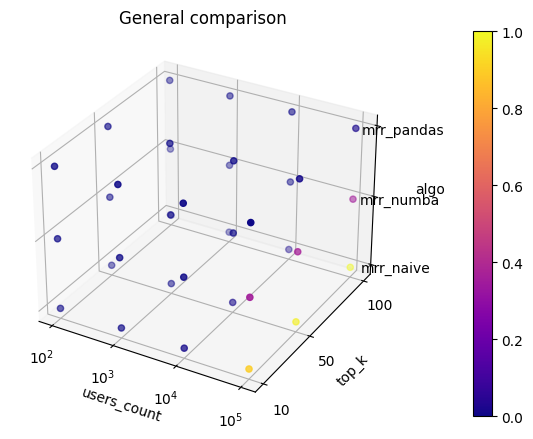

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111, projection='3d')

runtime = times['average_time(ms)'].values # Color dimension
X = np.log10(times['users_count'].values)
Y = times['top_k'].values  

z = times['algo'].values
vocab = {'mrr_naive': 0, 'mrr_numba': 1, 'mrr_pandas': 2}
Z = np.array([vocab[el] for el in z])

color_dimension = runtime
minn, maxx = color_dimension.min(), color_dimension.max()
color_dimension = (color_dimension - minn) / (maxx - minn)

img = ax.scatter(X, Y, Z, c=color_dimension, cmap=plt.cm.plasma)
fig.colorbar(img, ax=ax)

ax.set_xlabel('users_count')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_ylabel('top_k')
ax.set_yticks([10, 50, 100])
ax.set_zlabel('algo')
ax.set_zticks([0, 1, 2])
ax.set_zticklabels(["mrr_naive", 'mrr_numba', 'mrr_pandas'])

plt.title('General comparison')
plt.show()

Из-за большого разброса времен такое сравнение не совсем наглядное, поэтому лучше наверное сравнивать времена в пределах одного алгоритма для набора `users_count`, `top_k`, т.е. градацию цветов в пределах одного столбика.

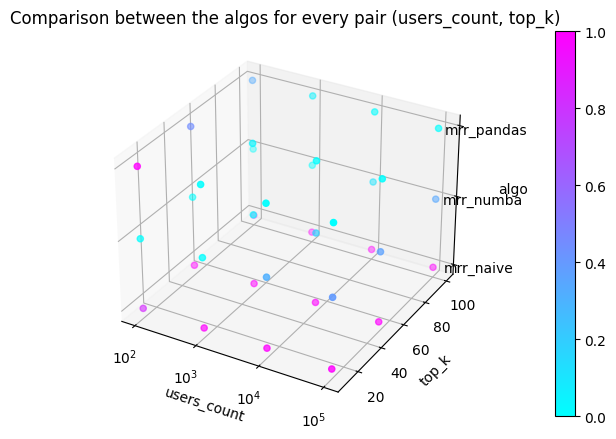

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111, projection='3d')

runtime = times['average_time(ms)'].values # Color dimension
X = np.log10(times['users_count'].values)
Y = times['top_k'].values  

z = times['algo'].values
vocab = {'mrr_naive': 0, 'mrr_numba': 1, 'mrr_pandas': 2}
Z = np.array([vocab[el] for el in z])

# Min-max nomalization within group of algos, i.e. columns in plot
color_dimension = runtime
for i in range(0, len(runtime), 3):
    minn, maxx = color_dimension[i:i+3].min(), color_dimension[i:i+3].max()
    color_dimension[i:i+3] = (color_dimension[i:i+3] - minn) / (maxx - minn)

img = ax.scatter(X, Y, Z, c=color_dimension, cmap=plt.cm.cool)
fig.colorbar(img, ax=ax)

ax.set_xlabel('users_count')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_ylabel('top_k')
ax.set_zlabel('algo')
ax.set_zticks([0, 1, 2])
ax.set_zticklabels(["mrr_naive", 'mrr_numba', 'mrr_pandas']) 

plt.title('Comparison between the algos for every pair (users_count, top_k)')
plt.show()

Видно, что "pandas" -  лидер по скорости выполнения во всех выборках с большим числом юзером (`users_count` > 1000), numba где-то посерединке между ним и naive.